# Recurrent Neural Networks

Can handle the sequential order in which words appear can have an important consequence for their combined meaning.
It can retaining some information about previous elements in a sequence, when considering a given element.

In [1]:


import importlib
import gensim
import nltk
import json
import numpy as np
import util
importlib.reload(util)
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch import nn

# IMPORT SOME BASIC TOOLS:
from pprint import pprint
import pyarrow



[nltk_data] Downloading package punkt to /home/vanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/vanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/vanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/vanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Activation Functions

The purpose of the function was to "squeeze" the values of our linear functions within a range of interest.

One popular function rectilinear that bound in the range of 0-1, that set all values above 1 to 1, and all less than 0 to 0. If the in our was generated by a linear function of some kind, then we would call a rectified linear unit $ReLU$

Both the and the have outputs that are non-negative. This is fine for modeling probabilities. If the value must be between -1 to 1 then the $tanh$ function can do it.

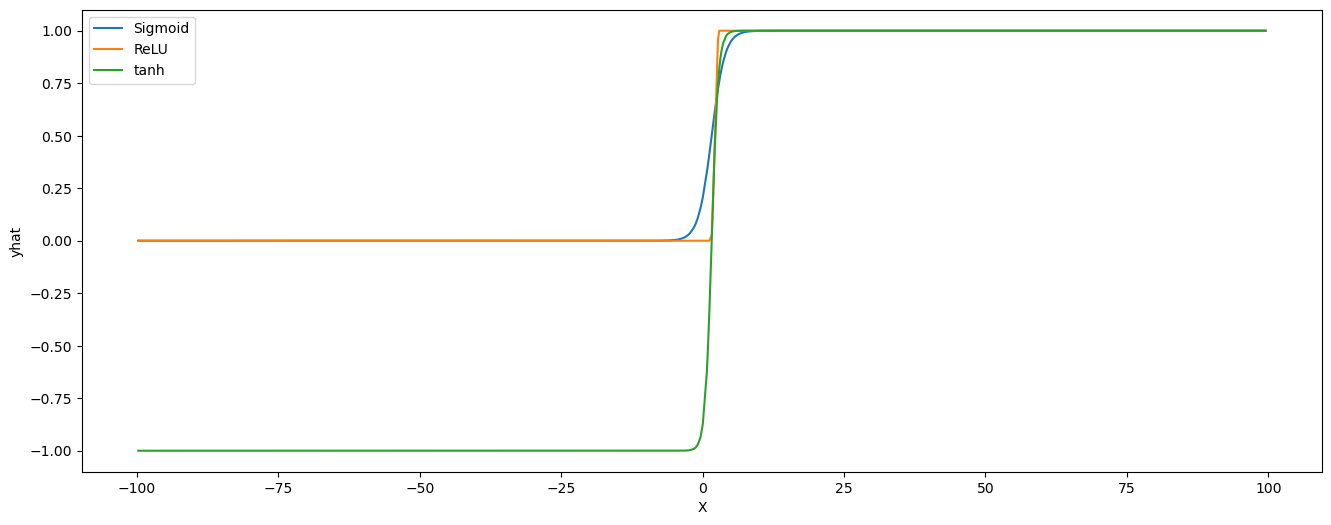

In [2]:


plt.figure(figsize = (16,6))

#-------------------------------------------------
# A Linear Function
#-------------------------------------------------
def linear(X,beta):
    return np.dot(X, beta[1:]) + beta[0]

#-------------------------------------------------
# A Sigmoid function
#-------------------------------------------------
def sigmoid(X):
    return 1/(1 + np.exp(-(X)))

#-------------------------------------------------
# A Recitfied Linear Unit
#-------------------------------------------------
def relu(X):
    # Rectify activations below 0
    X = np.maximum(np.zeros(np.shape(X)),X)
    
    #Recitfy activations above 1
    X = np.minimum(np.ones(np.shape(X)),X)

    return X

#-------------------------------------------------
# A Tanh 
#-------------------------------------------------
def tanh(X):
    t  =(np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
    return t

#-------------------------------------------------
# Compute yhat, given X and paramters beta
#-------------------------------------------------
X          = np.random.uniform(low= -100, high = 100, size = (1000,1))
beta       = np.random.normal(size = (np.shape(X)[1] + 1,1))
yhat_sig   = sigmoid(linear(X,beta))
yhat_relu  = relu(linear(X,beta))
yhat_tanh  = tanh(linear(X,beta))

#-------------------------------------------------
# Plot
#-------------------------------------------------
index  = np.argsort(X[:,0])
X, yhat_sig, yhat_relu, yhat_tanh = X[index,:], yhat_sig[index,:], yhat_relu[index,:], yhat_tanh[index,:]
plt.plot(X,yhat_sig,label="Sigmoid")
plt.plot(X,yhat_relu,label="ReLU")
plt.plot(X,yhat_tanh,label="tanh")
plt.xlabel('X');plt.ylabel('yhat')
plt.legend()
plt.show()



## LSTM

Pytorch require certain data format to be passed to it.

### 1. format data

In [ ]:



vocabulary = util.prepareVocabulary(vocab_json = 'materials/data/rt_reviews/vocabulary.json', remove_less_than = 25)

print('Number of words:', len(vocabulary))



### 2. One-Hot encoding

Way of representing text numerically
- for sentence-level processing used bag-of-words
- for word level-processing uses one-hot-encoding

In [3]:

#----------------------------------------------------
# Some Sample sentences
#----------------------------------------------------
sentences  = ['The move was very good.',                        
              'the movie was bad someverynonsensicalword',     
              'not good!']                                     


pprint(sentences)
print('\n')



['The move was very good.',
 'the movie was bad someverynonsensicalword',
 'not good!']




In [4]:
#----------------------------------------------------
# Tokenize the sentences
#----------------------------------------------------
for i,sentence in enumerate(sentences):
    sentences[i] = nltk.word_tokenize(gensim.utils.to_unicode(sentence.lower()))
    
pprint(sentences)
print('\n')


[['the', 'move', 'was', 'very', 'good', '.'],
 ['the', 'movie', 'was', 'bad', 'someverynonsensicalword'],
 ['not', 'good', '!']]




In [ ]:


#----------------------------------------------------
# One hot code
#----------------------------------------------------
onehot_sentences = util.onehot(list_of_tokenized_sentences = sentences, vocabulary = vocabulary)

pprint(onehot_sentences)
print('\n')



### 3. Tensor Preparation

most models (including networks) will expect a fixed length input tensor.But the simple sentences are different lengths because each has a different number of words! One way to handle this to padded the short one with <pad> token and assigned it at index 0 so all the sentences have the same length.

In [ ]:
#----------------------------------------------------
# Pad sentences so they are the same length
#----------------------------------------------------
seq_lengths = torch.LongTensor(list(map(len, onehot_sentences)))
print('sequence lengths:',seq_lengths)

seq_tensor = Variable(torch.zeros((len(onehot_sentences), seq_lengths.max()))).long()
for idx, (seq, seqlen) in enumerate(zip(onehot_sentences, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
    
print(seq_tensor)   


Transpose the Tensor
The tensor must be transposed to match PyTorch requirement format.

In [ ]:


# Note, must be transposed or Pytorch complains.
seq_tensor = seq_tensor.transpose(0,1)
print(seq_tensor)



In [ ]:
data_path     = '../../data/word_data/train_re_reviews.jsonl'
# max_sequence_length set to  the actual longest sentence in the text
X, X_lengths, y, end_flag = util.getTensorBatch(data_path, batch_number = 1, batch_size = 3, random_seed = 1, max_sequence_length=38)

print('X:',X)
print('\n')
print('y:',y)


4. Using Pre-trained embedded



In [ ]:
# Load the Glove embeddings and arrange the vector columns according to the word indicies

glove_embeddings = util.loadEmbeddings(path          = '../../data/word_data/glove.6B.100d.txt', 
                                        vocabulary    = vocabulary, 
                                        embedding_dim = 100)

In [ ]:
# Get the index of the word apple
apple_index = vocabulary.index('apple')

# Get the vector at that index
print(glove_embeddings[apple_index])

5. Model specification



In [ ]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    
    # Whenever an instance of a class is created, init function is automatically invoked. 
    # We will define all the layers that we will be using in the model
    def __init__(self, vocab_size, embedding_dim, embeddings, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()          
        
        #embedding layer
        self.embedding        = nn.Embedding(vocab_size, embedding_dim)  # This is a simple lookup table that turns the one-hot encodings into a vector - just like word2vec!
        self.embedding.weight = nn.Parameter(embeddings)                 # pretrained_weight is a numpy matrix of shape (num_embeddings, embedding_dim)
        
        # lstm layer
        self.lstm = nn.LSTM(embedding_dim,                        # Dimension of input
                            hidden_dim,                           # Number of hidden nodes
                            num_layers    = n_layers,             # Number of layers to be stacked
                            bidirectional = bidirectional,        # If True, uses a Bi directional LSTM
                            dropout       = dropout               # Introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout.
                           )
        
        # dense layer
        multiplier = 1 if bidirectional == False else 2
        self.fc    = nn.Linear(hidden_dim * multiplier, output_dim)
        
        # final activation function
        self.act = nn.Sigmoid()
    
    # This is where we chain together to layers to get the output we want
    def forward(self, text, text_lengths, bidirectional):
        
        # 1. Embedding: is used to convert the one-hot word representations into their
        #               Word vector representations. 
        embedded = self.embedding(text)
      
        # 2. Pack padding: tells the network to ignore the inputs that are `<pad>`. 
        #                  so that the outputs we generate are not influenced by the `<pad>` tokens; 
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        
        # 3. LSTM: is a variant of RNN that captures long term dependencies.
        #          Following some important parameters of LSTM that you should be familiar with. Given below are the parameters of this layer:Run the LSTM layer
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
      
        # 4. Concatenate: the final forward and backward hidden state
        hidden = hidden[-1,:,:] if bidirectional == False else torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        
        # 5. Linear: Connect to a densely connected linear layer
        dense_outputs =self.fc(hidden)
            

        # 6. ACtivation: Pass value to our sigmoid 
        outputs=self.act(dense_outputs)
        
        return outputs


In [ ]:


importlib.reload(utils)
import torch.optim as optim

#-------------------------------------------------
# setting hyperparameters
#-------------------------------------------------
data_path          = 'materials/data/rt_reviews/train_re_reviews.jsonl'
num_hidden_nodes   = 32
num_output_nodes   = 1
num_layers         = 2
bidirectional      = False
dropout            = 0.2
size_of_vocab      = len(vocabulary)
embeddings         = glove_embeddings
embedding_dim      = glove_embeddings.size()[1]

#-------------------------------------------------
# Instantiate the model
#-------------------------------------------------
model = classifier(size_of_vocab, embedding_dim,embeddings,num_hidden_nodes,
                   num_output_nodes, num_layers, bidirectional = bidirectional, dropout = dropout)

#-------------------------------------------------
# Set the optimizer
#-------------------------------------------------
optimizer       = optim.Adam(model.parameters())

#-------------------------------------------------
# Set the loss criterion
#-------------------------------------------------
criterion       = nn.BCELoss()

#-------------------------------------------------
# Optionally, push to GPU, if available
#-------------------------------------------------
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model     = model.to(device)
criterion = criterion.to(device)



In [ ]:
#architecture
print(model)


In [ ]:
importlib.reload(util)
print(f'The model has {util.count_parameters(model):,} trainable parameters')

In [ ]:
# Import a batch of data
data_path     = '../../data/word_data/train_re_reviews.jsonl'
X, X_lengths, y, end_flag = util.getTensorBatch(data_path, 
                                           batch_number        = 1, 
                                           batch_size          = 3,
                                           random_seed         = 1, 
                                           max_sequence_length = 50)

# Make sure that the model works by passing data into it, and seeing what comes out.
predictions = model(X, X_lengths, bidirectional).squeeze()        


print(predictions)

Batch Training the network

Write a function to train the LSTM classifier specified in the tutorial, above. Note that the procedure to train the model here will be almost identical to what we did in Homework 3. More specifically, your train function should allow you to:

    Train the model for multiple epochs,
    Break each epoch's training into multiple batches,
    generate your predictions (i.e. model(X, X_lengths).squeeze()) on each batch,
    compute the loss using the batch predictions and the batch labels (y).
    back-propagate the batch loss and compute gradients
    Update the model parameters
    Stop training when the validation set performance stops improving

Prove that your train function works by training the classifier for several batches and plotting the loss of the model on the training and validation sets. You are welcome to tweak the settings of the hyper-parameters, add or subtract layers, etc. as long as you use an LSTM

Please Note: In all likelihood your personal machines will not have the computational might (or time) required to train a perfect LSTM model with 1M parameters. You are not required to build a high-performance model here, rather, I just want to see that you can train and evaluate the model in batches. While it is not required, you can use the MSU High Performance Computing Cluster if you want to explore a greater variety of network settings, or improve the performance of the networks by exploring the hyper-parameters more carefully.